In [1]:
import numpy as np

from filters import FilterBase
from utils import (
    load_imu_data,
    euler_from_acce,
    plot_xyz
)

In [2]:
class EulerComplementaryFilter(FilterBase):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.p_hat = 0
        self.q_hat = 0
        self.phi = 0
        self.theta = 0
        self.psi = 0
        
        self.prev_del_phi = 0
        self.prev_del_theta = 0
        
    def update(self, dt, gyro, acce):
        p, q, r = gyro.reshape(3)
        phi_a, theta_a, _ = euler_from_acce(acce.reshape(-1, 3)).reshape(3)
        
        dot_phi, dot_theta, dot_psi = self.body_to_inertial(p, q, r)
        
        self.phi = self.phi + dt * (dot_phi - self.p_hat)
        self.theta = self.theta + dt * (dot_theta - self.q_hat)
        self.psi = self.psi + dt*dot_psi
        
        self.pi_law_phi(self.phi - phi_a)
        self.pi_law_theta(self.theta - theta_a)
        
    def get(self):
        return [self.phi, self.theta]
        
    def body_to_inertial(self, p, q, r):
        sin_phi = np.sin(self.phi)
        cos_phi = np.cos(self.phi)
        cos_theta = np.cos(self.theta)
        tan_theta = np.tan(self.theta)
        
        dot_phi   = p + q * sin_phi * tan_theta + r * cos_phi * tan_theta
        dot_theta =     q * cos_phi             - r * sin_phi
        dot_psi   =     q * sin_phi / cos_theta + r * cos_phi / cos_theta
        
        return dot_phi, dot_theta, dot_psi
    
    def pi_law_phi(self, del_phi):
        self.p_hat = self.p_hat + 0.1415 * del_phi - 0.1414 * self.prev_del_phi
        self.prev_del_phi = del_phi
    
    def pi_law_theta(self, del_theta):
        self.q_hat = self.q_hat + 0.1415 * del_theta - 0.1414 * self.prev_del_theta
        self.prev_del_theta = del_theta
        

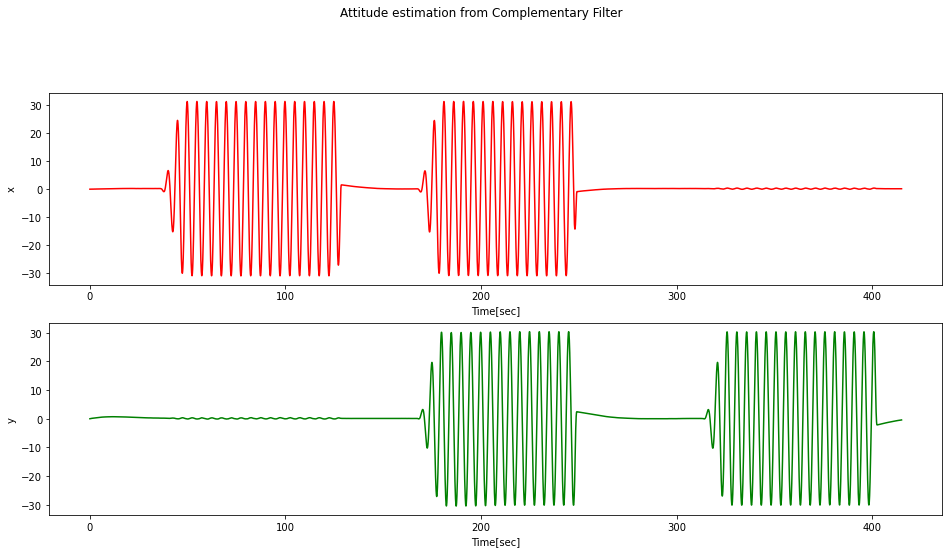

In [3]:
dt, ts, gyro, acce = load_imu_data()
cf = EulerComplementaryFilter()
euler = []
for t, g, a in zip(ts, gyro, acce):
    cf.update(dt, g, a)
    euler.append(cf.get())
    
euler = np.array(euler) * 180 / np.pi

plot_xyz(ts, euler, "Attitude estimation from Complementary Filter")